# Solving Wasserstein Gradient Flow using Sinkhorn's Algorithm
Throughout the notebook, let us adapt the following setting. For $n \in \mathbb{N}$, define $\Omega \subseteq \mathbb{R}^n$ be a compact subset of $n$ dimensional Euclidean space, and $\mathcal{P}(\Omega)$ be a space of Borel probability measures on $\Omega$. The 2-Wasserstein space is defined as a metric space of probability measures endowed with what so called a 2-Wasserstein metric $W_2: \mathcal{P}(\Omega) \times \mathcal{P}(\Omega) \to [0,\infty]$, defined as, $$W_2(\mu,\nu) = \left( \inf_{\gamma \in \Pi(\mu,\nu)} \int_{\Omega^2} \vert x-y\vert^2 d\gamma(x,y) \right)^{1/2}$$ where $\Pi(\mu,\nu) \coloneqq \{\gamma \in \mathcal{P}(\Omega^2) : \pi_{1}\sharp\gamma = \mu, \pi_{2}\sharp\gamma = \nu\}$.

In [1]:
from src.jko_lab import * # solvers
from src.utils import * # graphing utilities
import jax
import jax.numpy as jnp
import numpy as np
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
from jax import lax
import optax
from __future__ import annotations
from typing import Callable, Optional, Tuple, List
import flax.struct as flstr
Array = jnp.ndarray

## Wasserstein gradient flow
Given a functional $\mathcal{F} : \mathcal{P}_2(\Omega) \to \mathbb{R}$, a curve $(\rho_t)_{t\geq 0}$ in $\mathcal{P}_2(\Omega)$ is called a *Wasserstein gradient flow* of $\mathcal{F}$ if $$\frac{d\rho_t}{dt} = - \nabla_{W_2}F(\rho_t),$$ meaning that $\rho_t$ evolves in the direction of steepest descent of $\mathcal{F}$ with respect to the $W_2$ metric. If $\rho_t$ admits a Radon-Nikodym derivative, i.e. density, this Wasserstein gradient flow corresponds to the PDE $$\partial_t \rho_t = \nabla \cdot \left( \rho_t \nabla \frac{\delta \mathcal{F}}{\delta \rho} (\rho_t) \right).$$

## Entropic Optimal Transport

### Logarithmic-domain Sinkhorn's Algorithm
Following cells contain codes for visualizing the flow, sinkhorn's algorithm iterations, and etc.

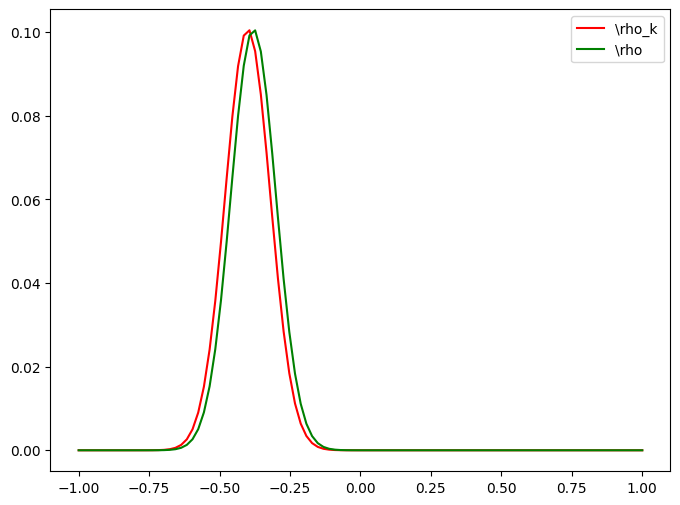

In [2]:
key = jax.random.PRNGKey(42)
n = 100

# 1D grid on [0,1]
x = jnp.linspace(0, 1, n)
C = (x[:,None] - x[None,:])**2 # cost matrix

# Target marginal rho_k (right marginal), a bimodal distribution
rho_k = jax.scipy.stats.norm.pdf(x, 0.3, 0.04)
rho_k = jnp.clip(rho_k, 1e-12, None)
rho_k = rho_k / rho_k.sum()

rho = jax.scipy.stats.norm.pdf(x, 0.3+1e-2, 0.04)
rho = rho / rho.sum()

plot_vectors(n, {
    "rho_k": rho_k,
    "rho": rho
    })

## Linear Potential Flow
Let $V$ be a lower bounded, lower semicontinuous, and convex function. Define $\mathcal{F}[\rho]: \mathcal{P}(\Omega) \to \mathbb{R}$ as
$$
\mathcal{F}[\rho] = \int_{\Omega} V d\rho.
$$
Such functional $\mathcal{F}[\rho]$ is called a linear potential. For instance, if $V=0$, then $\mathcal{F}[\rho]=0$ is a degenerate zero functional. Then, for any $\rho^0 \in \mathcal{P}(\Omega)$ and $k \geq 0$, JKO scheme attempts to solve
$$
\rho^{k+1} = \arg\min_{\rho}\left\{ \frac{W_2^2(\rho,\rho^{k})}{2\tau} \right\}.
$$
As $W_2^2$ is a metric on $\mathcal{P}(X)$, this minimum is achieved when $\rho=\rho^k=\rho^{k+1}$. Hence, for any $k \geq 1$, we must have $\rho^{k}=\rho^0$, i.e. a stationary flow.

### Setup
If $\mathcal{F}[\rho]$ is a linear potential, then we may reformulate the JKO scheme into Sinkhorn's algorithm with modified cost function. From the definition of entropic Wasserstein distance,
$$
W_{2,\epsilon}^2(\rho,\rho^k) = \arg\min_{\gamma \in \Pi(\rho,\rho^k)} \left\{\int_{\Omega^2} C(x,y) d\gamma + \varepsilon \int_{\Omega^2} \gamma (\log \gamma-1) d\gamma\right\}.
$$
The entropic JKO scheme yields
$$
\rho^{k+1} = \underset{\rho \in \mathcal{P}(\Omega)}{\arg\min} \left\{ \int_\Omega V d\rho + \frac{1}{2\eta} \underset{\gamma \in \Pi(\rho,\rho^k)}{\arg\min} \left[ \int_{\Omega^2} C(x,y) d\gamma + \epsilon \int_{\Omega^2} \gamma(\log \gamma - 1) d \gamma\right] \right\}
$$
which is the same as
$$
\rho^{k+1} = \underset{\rho \in \mathcal{P}(\Omega)}{\arg\min} \underset{\gamma \in \Pi(\rho,\rho^k)}{\min} \left\{ \int_\Omega V d\rho + \frac{1}{2\eta} \int_{\Omega^2} C(x,y) d\gamma + \epsilon \int_{\Omega^2} \gamma(\log \gamma - 1) d \gamma \right\}
$$
If $\gamma$, $\rho$, and $\rho^k$ are absolutely continuous with respect to Lebesgue measure as well as $\gamma \in \Pi(\rho,\rho^k)$, then
$$
\int_{\Omega} V d\rho = \int_{\Omega} V(x) \rho(x) dx = \int_{\Omega} V(x) \left( \int_{\Omega} \gamma(x,y) dy \right) dx = \int_{\Omega^2} V(x) \gamma(x) dydx = \int_{\Omega^2} V d\gamma
$$
because $\int_{\Omega} \gamma(x,y) dy = \rho(x)$. Then,
$$
\rho^{k+1} = \underset{\rho \in \mathcal{P}(\Omega)}{\arg\min} \underset{\gamma \in \Pi(\rho,\rho^k)}{\min} \frac{1}{2\eta} \left\{ \int_\Omega^2 C+2\eta V d\gamma + \epsilon \int_{\Omega^2} \gamma(\log \gamma - 1) d \gamma \right\}
$$
which is an entropic optimal transport problem with a new cost $\tilde{C}(x,y)=C(x,y)+2\eta V(x)$.

In [3]:
eta = 1e-2 # JKO step size
epsilon = 1e-4 # Sinkhorn regularization parameter

# Run solver
solver = Sinkhorn(
    C=C,
    a=rho,
    b=rho_k,
    epsilon=epsilon,
    max_iters=2000,
    tol=1e-9
)

# extract outputs
pi, f, g, error, iters = solver.solve()
# print basic info
print("Column feasibility ||pi^T 1 - rho_k||:", float(jnp.linalg.norm(col_sums(pi) - rho_k)))
print(f"Convergence in {iters} iterations")
print("Mass check (should be 1):", float(rho.sum()))

Column feasibility ||pi^T 1 - rho_k||: 2.0041068779425864e-16
Convergence in 531 iterations
Mass check (should be 1): 0.9999999999999999


The performance of the algorithm is measured by the following.

Text(0.5, 1.02, 'Summary of Sinkhorn Algorithm')

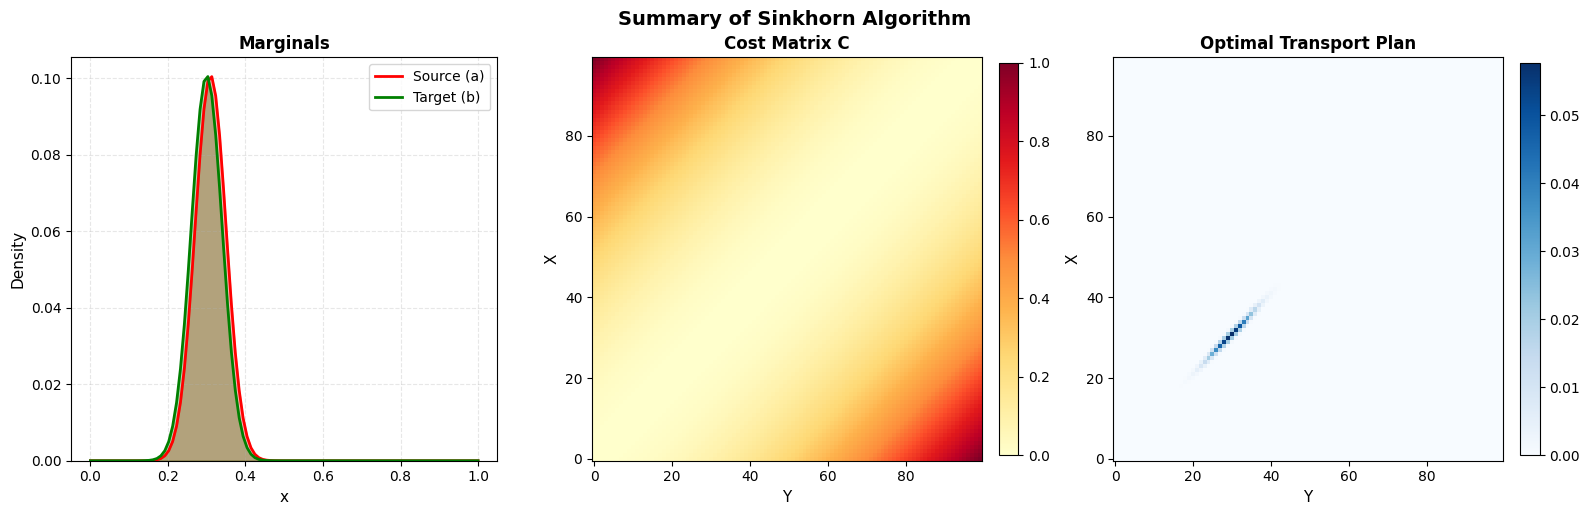

In [4]:
# Create summary
fig = plot_sinkhorn_summary(
    C=C,
    a=rho,
    b=rho_k,
    pi=pi,
    x_source=x,
    x_target=x,
    figsize=(16, 5)
)
plt.suptitle(f'Summary of Sinkhorn Algorithm', fontsize=14, fontweight='bold', y=1.02)

## Entropy Flow
Shannon entropy $\mathcal{F}[\rho]: \mathcal{P}(\Omega) \to \mathbb{R}$ is a functional defined by
$$
F[\rho] = \int_{\Omega} \rho (\log \rho - 1) \: d\rho.
$$
Then, by taking $\mathcal{F}[\rho]$ as an external potential for the following entropic JKO scheme
$$
\rho^{k+1} = \underset{\rho \in \mathcal{P}(\Omega)}{\arg\min} \left\{ \int_{\Omega} \rho (\log \rho - 1) d\rho + \frac{1}{2\eta} W_{2,\epsilon}^2(\rho,\rho^k) \right\},
$$
as JKO step size $\eta \to 0$, corresponding Wasserstein gradient flow $(\rho^{k})_{k\in \mathbb{N}}$ approximates the heat equation
$$
\partial_t \rho_t = \nabla \cdot (\nabla \rho)
$$
with $\rho_0 = \rho^0 \in \mathcal{P}(\Omega)$.

### Setup
Upon spatial discretization in $n$ grid points, we get the explicit formulation of discrete Shannon entropy as
$$\mathcal{F}[\rho] = \sum_{i=1}^{n} \rho_i (\log \rho_i - 1)$$
with $\rho \in \Sigma_n$.

In [5]:
def F_shannon_entropy(rho: jax.Array) -> jax.Array:
    """
    Shannon entropy of a probability measure rho
    """
    rho_safe = jnp.clip(rho, 1e-12, None) # prevent log(0)
    return jnp.sum(rho_safe * (jnp.log(rho_safe)) - 1.0)

In this test, we aim to flow for a total time $T=215$. Let us start from a bimodal initial distribution $\rho^0 = 0.5\mathcal{N}(0.25,0.03)+0.5\mathcal{N}(0.75,0.04)$.

In [13]:
n = 1000             # spatial discretization                
T_TARGET = 50        # total time of the flow

# initial measure
rho0 = 0.5 * jax.scipy.stats.norm.pdf(x, 0.25, 0.03) + 0.5 * jax.scipy.stats.norm.pdf(x,0.75,0.04)
rho0 = jnp.clip(rho0, 1e-12, None); rho0 = rho0 / rho0.sum()

x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

Due to the nature of heat equation, as $k \to \infty$, sequence of probability measures $\rho^k$ generated from the scheme should converge to an uniform distribution $b \in \mathcal{P}(\Omega)$.

In [14]:
# target measure is uniform
b = jnp.ones_like(x)/n
b = b / b.sum()

The numerical stability of the scheme is sharply determined by the choice of $\eta$ and $\epsilon$. After running a hyperparameter optimization on $(\eta, \epsilon)$, it found that $\eta = 10^{-2}$ and $\epsilon = 15$ are optimal.

In [ ]:
eta = 1e-2                              # JKO step size
epsilon = 1e-4                          # regularization parameter of inner Sinkhorn iterations
sinkhorn_max_iters = 2000               # maximum number of inner Sinkhorn iterations
jko_tol = 1e-10                         # tolerance for inner Sinkhorn approximation
jko_lr = 0.01                           # learning rate of outer SGD iterations
jko_inner_steps = 10                    # number of outer SGD iterations
num_jko_steps = int(T_TARGET / eta)     # automatically determined by eta

Run the scheme with chosen parameters.

In [ ]:
def entropy(r):
    r = jnp.clip(r, 1e-12, None)
    return -jnp.sum(r * jnp.log(r))

jko_flow = SinkhornJKO(
    C=C,                                # Euclidean distance matrix
    rho0=b,                             # starting marginal
    eta=eta,                            # JKO step size
    epsilon=epsilon,                    # regularization parameter
    F_func=F_shannon_entropy,           # external potential
    sinkhorn_iters=sinkhorn_max_iters,  # set to 2,000
    inner_steps=jko_inner_steps,        # set to 10
    tol=jko_tol,                        # set to 1e-9
    learning_rate=jko_lr,               # set to 0.01
    optimizer_name='sgd'                # may choose adam, sgd, or etc.
)

print(f"Starting JKO flow with eps={epsilon} eta={eta} tol={jko_tol}...")
rhos, diag = jko_flow.compute_flow(num_steps=num_jko_steps)
print("Flow computation finished.")

print("Computing L2 errors of measures...")
dists = jnp.linalg.norm(rhos - b[None, :], axis=1)
print("Computing Entropy of measures...")
Hs = jnp.array([entropy(r) for r in rhos])

# Check for convergence
uniform_H = entropy(b)
print(f"\nTarget Uniform Entropy: {float(uniform_H):.6f}")

print("[Flow-Entropy] Entropy should increase, distance to uniform should decrease:")
k_steps_to_print = [i for i in [0, 10, 50, 100, 500, 1000, 2500, num_jko_steps-1] if i < num_jko_steps]

for k in k_steps_to_print:
    print(f" k={k:3d}: H={float(Hs[k])}, ||rho-b||={float(dists[k])}")

Starting JKO flow with eps=0.0001 eta=0.01 tol=1e-09...
Flow computation finished.
Computing L2 errors of measures...
Computing Entropy of measures...

Target Uniform Entropy: 6.907755
[Flow-Entropy] Entropy should increase, distance to uniform should decrease:
 k=  0: H=6.907755, ||rho-b||=0.000000
 k= 10: H=6.907755, ||rho-b||=0.000000
 k= 50: H=6.907755, ||rho-b||=0.000000
 k=100: H=6.907755, ||rho-b||=0.000000
 k=500: H=6.907755, ||rho-b||=0.000000
 k=1000: H=6.907755, ||rho-b||=0.000001
 k=2500: H=6.907755, ||rho-b||=0.000002
 k=4999: H=6.907755, ||rho-b||=0.000004


Let's roughly implement the adaptive JKO flow by manually running the flow using semigroup property.

### Convergence and Diagnostics
For each $k\in 0$, run the following JKO scheme with Sinkhorn and SGD approximation
$$
\rho^{k+1} = \underset{\rho \in \Sigma_n}{\arg\min} \left\{ \sum_{i=1}^{n} \rho_i(\log\rho_i-1) + \frac{1}{2\eta}

\sup_{f,g \in \mathbb{R}^n} \left[ \sum_{i=1}^{n} f_i \rho_i + \sum_{i=1}^{n} g_i \rho^k_i - \sum_{i,j}  \right]


W_{2,\epsilon}^2(\rho,\rho^k) \right\}
$$
where the initial measure $\rho^0 = \mathcal{N}(0.1, 0.04)$ is taken to be Gaussian. In this example, let us flow for a total $T = \eta \times n = 2$ where $\eta$ and $n$ are JKO step size and the number of JKO steps, respectively.

Let us verify the convergence of the algorithm. As the heat equation must flow to maximize the entropy $$E[\rho] = -\int \rho \log \rho d\rho,$$ we should witness an increment in entropy and decrement in distance to uniform target marginal.

In [ ]:
def entropy(r):
    r = jnp.clip(r, 1e-12, None)
    return -jnp.sum(r * jnp.log(r))

# Check for convergence
uniform_H = entropy(b)
print(f"\nTarget Uniform Entropy: {float(uniform_H):.6f}")

print("[Flow-Entropy] Entropy should increase, distance to uniform should decrease:")
k_steps_to_print = [i for i in [0, 10, 50, 100, 500, 1000, 2500, num_jko_steps-1] if i < num_jko_steps]

for k in k_steps_to_print:
    print(f" k={k:3d}: H={float(Hs[k]):.6f}, ||rho-b||={float(dists[k]):.6f}")

The following diagnostic illustrates how warm starting JKO steps with Kantorovich potentials from previous step benefits the convergence speed of the algorithm.

In [ ]:
x = np.linspace(0, num_jko_steps, num_jko_steps+1)
sinkhorn_iters_per_jko = np.insert(np.asarray(diag['sinkhorn_iters_per_jko_step']),0, 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f"JKO Flow Diagnostics (Shannon Entropy, $\\eta={eta}$, Total JKO steps={num_jko_steps})", fontsize=14)

# Plot 1: Sinkhorn Iterations
axes[0].plot(x, sinkhorn_iters_per_jko, linestyle='-', color='tab:blue', linewidth=1)
axes[0].set_title('Sinkhorn Iters per JKO Step', fontsize=12)
axes[0].set_xlabel('JKO Step ($k$)', fontsize=11)
axes[0].set_ylabel('Total Sinkhorn Iterations (log scale)', fontsize=11)
axes[0].set_yscale('log')
axes[0].grid(True, which="both", linestyle='--', alpha=0.6)
axes[0].tick_params(axis='y', which='minor', labelsize=8)

# Plot 2: Entropy
axes[1].plot(x, Hs, linestyle='-', color='tab:red', linewidth=1)
axes[1].axhline(y=float(uniform_H), color='k', linestyle='--', label=r'$H(\mathbf{b}) \approx 4.605$')
axes[1].set_title('Entropy $H(\\rho^k)$', fontsize=12)
axes[1].set_xlabel('JKO Step ($k$)', fontsize=11)
axes[1].set_ylabel('Entropy (nats)', fontsize=11)
axes[1].set_ylim(bottom=Hs.min() - 0.1)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# Plot 3: Distance
axes[2].plot(x, dists, linestyle='-', color='tab:green', linewidth=1)
axes[2].set_title(r'Distance to Uniform $||\rho^k - \mathbf{b}||_2$', fontsize=12)
axes[2].set_xlabel('JKO Step ($k$)', fontsize=11)
axes[2].set_ylabel(r'Euclidean Distance', fontsize=11)
axes[2].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[2].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

The following cell describes the flow in animated histograms.

In [ ]:
html = animate_hist_flow(  
    mu_list=rhos, x=np.asarray(x),
    target=b,
    interval=50,
    title="JKO Flow (Shannon Entropy)"
)
html

## Kullback-Leibler Divergence Flow
Kullback-Leibler (KL) divergence is defined by $$\mathcal{F}[\rho] = \int_\Omega V d\rho + \int_\Omega \rho\log\rho d\rho.$$ As the JKO stepsize $\tau \to 0$, Wasserstein gradient flow approximates the Fokker-Planck equation.

### Setup
Upon discretization, we get
$$F[\rho] = \sum_{i=1}^{n} V_i \rho_i + \sum_{i=1}^{n} \rho_i \log \rho_i$$
with $V \in \mathbb{R}^n$.

### Convergence and Diagnostics
For each $k\in 0$, run the following JKO scheme with Sinkhorn and SGD approximation
$$
\rho^{k+1} = \arg\min_{\rho \in \mathcal{P}(\Omega)} \left\{ F[\rho] + \frac{1}{2\eta}W_{2,\epsilon}^2(\rho,\rho^k) \right\}
$$
where the initial measure $\rho^0 = \mathcal{N}(0.1, 0.04)$ is taken to be Gaussian. In this example, let us flow for a total $T = \eta \times n = 2$ where $\eta$ and $n$ are JKO step size and the number of JKO steps, respectively.

Let us verify the convergence of the algorithm.

The following cell describes the flow in animated histograms.

In [ ]:
html = animate_hist_flow(
    mu_list=rhos, x=np.asarray(x),
    target=b,                # or None
    interval=50,
    title="JKO Flow (KL Divergence)"
)
html

## Porous Media Equation
Let $\mathcal{F}[\rho]$ an external potential be defined as $$\mathcal{F}[\rho]=\frac{1}{m-1}\int_{\Omega}\rho^m d\rho,$$ for $m\geq 1$. The corresponding JKO flow is defined as
$$
\rho^{k+1} = \underset{\rho\in\mathcal{P}(\Omega)}{\arg\min}\left\{ \frac{1}{m-1}\int_{\Omega}\rho^m d\rho + \frac{W_2^2(\rho,\rho^k)}{2\eta} \right\}
$$
for each $k \geq 1$. Then, as the JKO stepsize $\tau \to 0$, this Wasserstein gradient flow approximates the Porous media equation given by
$$\partial_t \rho_t = \nabla^2 \mathcal{F}(\rho) = \nabla \cdot (\nabla \mathcal{F}(\rho))$$

### Setup
Upon discretization, we get
$$F[\rho] = \frac{1}{m-1}\sum_{i=1}^{n} \rho_i^m$$
with $m \in \mathbb{N}$.

In [ ]:
def F_porous_media(rho, m=2):
    return jnp.sum(jnp.power(rho, m)) /(m-1)

n = 300
x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

# initial rho0 bimodal distribution
rho0 = 0.6 * jax.scipy.stats.norm.pdf(x, 0.3, 0.04) + 0.4 * jax.scipy.stats.norm.pdf(x, 0.75, 0.05)
rho0 = jnp.clip(rho0, 1e-18, None); rho0 = rho0 / rho0.sum()

m = 1.1 # try 1.5 or 3.0 as well

# target marginal is uniform distribution
b = jnp.ones_like(x) / n

def l2_to_uniform(r):
    return float(jnp.linalg.norm(r - b))

def rmax(r):
    return float(jnp.max(r))

Choose the parameters for JKO flow.

In [ ]:
eta = 1e-2                 # Reasonable JKO time step (1/eta = 20)
epsilon = 1e-3            # Fine-grained OT regularization
sinkhorn_max_iters = 2000 # Give Sinkhorn *plenty* of room to converge
jko_inner_steps = 10      # Fewer inner steps, but with good gradients
jko_tol = 1e-6            # Relaxed tolerance
jko_lr = 0.005            # More stable inner learning rate
num_jko_steps = 200       # Total time T = 200 * 0.1 = 20

print("[Flow-PorousMedia] toward uniform (expect ||rho-b|| ↓, max(rho) ↓):")
for k in [0, 1, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500]:
    r = rhos[k]
    print(f"  k={k:2d}: ||rho-b||={l2_to_uniform(r):.6f}, max(rho)={rmax(r):.6f}")

In [ ]:
jko_flow = SinkhornJKO(
    C=C,
    rho0=rho0,
    eta=eta,
    epsilon=epsilon,
    F_func=F_porous_media,
    sinkhorn_iters=sinkhorn_max_iters, # Use the new value
    inner_steps=jko_inner_steps,       # Use the new value
    tol=jko_tol,                       # Use the new value
    learning_rate=jko_lr,              # Use the new value
    optimizer_name='adam'
)

print("Starting JKO flow...")
# rhos, diag = jko_flow.compute_flow(num_steps=num_jko_steps)
print("Flow computation finished.")
print(diag)

b = jnp.ones_like(x)/n
print("Computing errors")
dists = jnp.linalg.norm(rhos - b[None, :], axis=1)
print("Computing entropy")
Hs = jnp.array([entropy(r) for r in rhos])

# Check for convergence
uniform_H = entropy(b)
print(f"\nTarget Uniform Entropy: {float(uniform_H):.6f}")

print("[Flow-Entropy] Entropy should increase, distance to uniform should decrease:")
# Print steps 0, 1, 5, 10, 20, 30, 40, 49
k_steps_to_print = [i for i in [0, 1, 5, 10, 20, 30, 40, num_jko_steps-1] if i < num_jko_steps]

for k in k_steps_to_print:
    print(f" k={k:3d}: H={float(Hs[k]):.6f}, ||rho-b||={float(dists[k]):.6f}")

# This check is just for the last step
if k_steps_to_print:
    k_last = k_steps_to_print[-1]
    print(f" k={k_last:3d}: H={float(Hs[k_last]):.6f}, ||rho-b||={float(dists[k_last]):.6f}")

print("\nGenerating animation (this may take a moment)...")

### Convergence and Diagnostics
For each $k\in 0$, run the following JKO scheme with Sinkhorn and SGD approximation
$$
\rho^{k+1} = \arg\min_{\rho \in \mathcal{P}(\Omega)} \left\{ F[\rho] + \frac{1}{2\eta}W_{2,\epsilon}^2(\rho,\rho^k) \right\}
$$
where the initial measure $\rho^0 = \mathcal{N}(0.1, 0.04)$ is taken to be Gaussian. In this example, let us flow for a total $T = \eta \times n = 2$ where $\eta$ and $n$ are JKO step size and the number of JKO steps, respectively.

Let us verify the convergence of the algorithm.

The following cell describes the flow in animated histograms.

In [ ]:
html = animate_hist_flow(
    mu_list=rhos, x=np.asarray(x),
    target=b,                # or None
    interval=50,
    title="JKO Flow (Porous Media Divergence)"
)
html

## $\chi$-square Divergence Flow
Let $\mathcal{F}[\rho]$ an external potential be defined as $$\mathcal{F}[\rho] = \int_{\Omega} \left(\frac{d\rho}{d\nu}-1\right)^2 d\nu$$ where $\rho$ is absolutely continuous with respect to $\nu$. By Radon-Nikodym theorem, $\rho$ admits a density, i.e. Radon-Nikodym derivative $\frac{d\rho}{d\nu}$.

### Setup
Upon discretization, we get $$F[\rho] = \sum_{i=1}^{n} \frac{\rho_i^2}{\nu_i}$$

In [ ]:
# Chi-square divergence
def F_chi_square_div(
        rho: jnp.ndarray,
        b: jnp.ndarray
    ) -> jnp.ndarray:
    """
    Chi-square divergence of probability measure rho given a reference measure b
    """
    b = jnp.clip(b, 1e-8, None)
    return jnp.sum(jnp.divide(jnp.power(rho, 2), b))

n = 512
x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

# initial
rho0 = jax.scipy.stats.norm.pdf(x, 0.1, 0.04)
rho0 = jnp.clip(rho0, 1e-18, None); rho0 = rho0 / rho0.sum()

# Target marginal b
b = jax.scipy.stats.cauchy.pdf(x, 0.7, 0.2)
b = b / b.sum()

### Convergence and Diagnostics
For each $k\in 0$, run the following JKO scheme with Sinkhorn and SGD approximation
$$
\rho^{k+1} = \arg\min_{\rho \in \mathcal{P}(\Omega)} \left\{ F[\rho] + \frac{1}{2\eta}W_{2,\epsilon}^2(\rho,\rho^k) \right\}
$$
where the initial measure $\rho^0 = \mathcal{N}(0.1, 0.04)$ is taken to be Gaussian. In this example, let us flow for a total $T = \eta \times n = 2$ where $\eta$ and $n$ are JKO step size and the number of JKO steps, respectively.

In [ ]:
# JKO Flow parameters
eta = 1e-2

# Run JKO scheme with Sinkhorn algorithm

# verify convergence
def dist(r):
    return float(jnp.linalg.norm(r-b))

print("[Flow-chi2] Expect ||rho-b|| to decrease")
for k in [0, 1, 5, 10, 20, 40, 60, 80, 100]:
    print(f"  k={k:2d}: ||rho-b||={dist(rhos[k]):.6f}")

Let us verify the convergence of the algorithm.

In [ ]:
b = jax.nn.softmax(-((x-0.6)**2)/0.02)
b = b / jnp.sum(b)

n = 600
x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

rho0 = jax.scipy.stats.norm.pdf(x, 0.2, 0.05)
rho0 = jnp.clip(rho0, 1e-12, None); rho0 = rho0 / rho0.sum()

@jax.jit
def F_value_entropy(rho):
    b = jax.nn.softmax(-((x-0.6)**2)/0.02)
    b = jnp.clip(b, 1e-300, None) # avoid log(0)
    b = b / jnp.sum(b)
    return jnp.dot(rho, jnp.log(jnp.divide(rho,b)) - jnp.ones_like(b))

# set up new hyperparameters
eta = 1e-3                 
epsilon = 15           
sinkhorn_max_iters = 2000 
jko_inner_steps = 10      
jko_tol = 1e-9            
jko_lr = 0.01            
num_jko_steps = 600       

jko_flow = SinkhornJKO(
    C=C,
    rho0=rho0,
    eta=eta,
    epsilon=epsilon,
    F_func=F_value_entropy,
    sinkhorn_iters=sinkhorn_max_iters, 
    inner_steps=jko_inner_steps,       
    tol=jko_tol,              
    learning_rate=jko_lr,
    optimizer_name='sgd'
)

print("Starting JKO flow...")
rhos, diag = jko_flow.compute_flow(num_steps=num_jko_steps)
print("Flow computation finished.")

print("Computing L2 errors of measures...")
dists = jnp.linalg.norm(rhos - b[None, :], axis=1)

# Check for convergence
for k in [0, 1, 5, 10, 20, 40, 50, 100, 200, 300, 400, 500, 600]:
    print(f"k={k:2d}: ||rho-b||={float(dists[k]):.6f}")

The following cell describes the flow in animated histograms.

In [ ]:
html = animate_hist_flow(
    mu_list=rhos, x=np.asarray(x),
    target=b,                # or None
    interval=50,
    title="JKO Flow (Porous Media Divergence)"
)
html

## Porous Media Divergence Flow
Let $V$ be a lower bounded, lower semicontinuous, and convex function. Let $\mathcal{F}[\rho]$ be an external potential be defined as $$\mathcal{F}[\rho] = \int_{\Omega} V d\rho + \frac{1}{m-1}\int_{\Omega} \rho^m d\rho$$ for some $m \geq 1$. If $V=0$ is identically zero, then porous media divergence is equivalent to the potential given in porous media equation.

### Setup
Upon discretization, we get $$F[\rho] = \sum_{i=1}^{n} -\rho_i\log b_i + \frac{1}{m-1}\sum_{i=1}^{n} \rho^m_{i}$$ for a given $m \geq 1$.

In [ ]:
# problem setup
def F_porous_divergence(rho, V, m):
    """
    Porous Media Divergence of rho given m >= 1 and potential vector V
    """
    
    return jnp.dot(V,rho)+(jnp.sum(jnp.power(rho,m)))/(m-1)

# dimensionality
n = 128
x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

# initial distribution: bimodal, non-uniform
rho0 = 0.7 * jax.scipy.stats.norm.pdf(x, 0.25, 0.05) + 0.3 * jax.scipy.stats.norm.pdf(x, 0.75, 0.06)
rho0 = jnp.clip(rho0, 1e-18, None); rho0 = rho0 / rho0.sum()

# target marginal: gaussian
mu, sigma = 0.6, 0.07
b = jax.scipy.stats.norm.pdf(x, mu, sigma)
b = jnp.clip(b, 1e-18, None); b = b / b.sum()

m = 1.5 # try 1.2, 1.5, 2.0 (all displacement-convex for m>=1)

### Convergence and Diagnostics
For each $k\in 0$, run the following JKO scheme with Sinkhorn and SGD approximation
$$
\rho^{k+1} = \arg\min_{\rho \in \mathcal{P}(\Omega)} \left\{ F[\rho] + \frac{1}{2\eta}W_{2,\epsilon}^2(\rho,\rho^k) \right\}
$$
where $m=1.5$, $\rho^0 = \mathcal{N}(0.6, 0.07)$. In this example, let us flow for a total $T = \eta \times n = 20$ where $\eta$ and $n$ are JKO step size and the number of JKO steps, respectively.

In [ ]:
jko_flow = SinkhornJKO(
    C=C,
    rho0=rho0,
    eta=1e-1,
    epsilon=5e-1,
    F_func=F_porous_divergence,
    sinkhorn_iters=2000, 
    inner_steps=10,       
    tol=1e-9,              
    learning_rate=0.01,
    optimizer_name='adam'
)

jko_flow.compute_flow(num_steps=200)

Let us verify the convergence of the algorithm.

In [ ]:
# check for convergence
def dist_to_b(r):
    return float(jnp.linalg.norm(r - b))

def mass_near_center(r, rad=2*sigma):  # mass within ~2σ of mu
    return float(jnp.sum(r * (jnp.abs(x - mu) <= rad)))

print("[Flow-Porous+V(b)] toward Gaussian target b (expect ||rho-b|| ↓, mass near mu ↑):")
for k in [0, 1, 5, 10, 20, 40, 50, 100, 200, 300, 400, 500, 600]:
    r = rhos[k]
    print(f"  k={k:2d}: ||rho-b||={dist_to_b(r):.6f}, mass(|x-mu|<=2σ)={mass_near_center(r):.6f}")

The following cell describes the flow in animated histograms.

In [ ]:
html = animate_hist_flow(
    mu_list=rhos, x=np.asarray(x),
    target=b,                # or None
    interval=50,
    title="JKO Flow (Porous Media Divergence)"
)
html